In [1]:
%matplotlib inline

Load necessary libraries and dataset. (Replace correct path for dataset)

In [2]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch import nn
from transformers import RobertaModel
from transformers import RobertaTokenizer, RobertaConfig

In [94]:
df = pd.read_csv("/content/track-a.csv").fillna(' ')
df = df.drop(columns=['id'])
print(df.head())

                                                text  anger  fear  joy  \
0                       Colorado, middle of nowhere.      0     1    0   
1  This involved swimming a pretty large lake tha...      0     1    0   
2        It was one of my most shameful experiences.      0     1    0   
3  After all, I had vegetables coming out my ears...      0     0    0   
4                        Then the screaming started.      0     1    0   

   sadness  surprise  
0        0         1  
1        0         0  
2        1         0  
3        0         0  
4        1         1  


Label distribution:
anger is under represented followed by joy.

In [95]:
class_names = ['anger', 'fear', 'joy', 'sadness', 'surprise']
class_counts = df[class_names].sum()
print("Number of samples per class:")
print(class_counts)

Number of samples per class:
anger        333
fear        1611
joy          674
sadness      878
surprise     839
dtype: int64


Split the data into train and test sets.

In [96]:
texts = df["text"].tolist()
labels = df[class_names].values
texts_train, texts_test, labels_train, labels_test = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)
label_df = pd.DataFrame(labels_train, columns=class_names)
text_df = pd.DataFrame({'text': texts_train})
train_df = pd.concat([text_df, label_df], axis=1)

In [97]:
texts_train = train_df["text"].tolist()
labels_train = train_df[class_names].values

Load the tokenizer for roberta-base model to add word embedding for train and test data.

In [98]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
encodings_train = tokenizer(texts_train, truncation=True, padding=True, max_length=128)
encodings_test = tokenizer(texts_test, truncation=True, padding=True, max_length=128)

Define a custom PyTorch Dataset class named EmotionDataset and then use it to create training and testing datasets.

In [99]:
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = EmotionDataset(encodings_train, labels_train)
test_dataset = EmotionDataset(encodings_test, labels_test)

Define various metrics to be calculated on test data over epochs to evaluate the model for classification accuracy, overfitting.

In [100]:
from sklearn.metrics import accuracy_score, f1_score, hamming_loss, roc_auc_score
import numpy as np

def compute_metrics(eval_pred):
    logits, true_labels = eval_pred
    probs = 1 / (1 + np.exp(-logits))
    metrics = {}

    for thresh in [0.5, 0.7]:
        preds = (probs >= thresh).astype(int)
        metrics[f'accuracy_t{thresh}'] = accuracy_score(true_labels, preds)
        metrics[f'micro_f1_t{thresh}'] = f1_score(true_labels, preds, average='micro', zero_division=0)
        metrics[f'macro_f1_t{thresh}'] = f1_score(true_labels, preds, average='macro', zero_division=0)
        metrics[f'hamming_loss_t{thresh}'] = hamming_loss(true_labels, preds)

    try:
        metrics["micro_auc"] = roc_auc_score(true_labels, probs, average="micro")
    except ValueError:
        metrics["micro_auc"] = 0.0

    return metrics

Load a pre-trained RoBERTa model and prepares it for multi-label sequence classification.

In [90]:
model = AutoModelForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=len(class_names),
    problem_type="multi_label_classification"
)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


 Create a TrainingArguments object from the Hugging Face Transformers library. These arguments configure how the model will be trained and evaluated using the Trainer API.
1.   Batch Size : smaller batch size of 16 as our dataset is small
2.   Learning rate : smaller learning rate of 1e-5 proves better convergence of model to avoid overfitting
3.   Weight decay : added weight decay to better generalise model and avoid higher weight values.





In [101]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=6,
    logging_dir="./logs",
    save_strategy="epoch",
    load_best_model_at_end=True,
    logging_steps=10,
    learning_rate=1e-5,
    weight_decay=0.01,
)

Use Trainer object from transformer library to train model with custom metrics function and evaluation during epochs.
Here we have used test dataset as validation dataset as dataset is small.

In [102]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

In [103]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy T0.5,Micro F1 T0.5,Macro F1 T0.5,Hamming Loss T0.5,Accuracy T0.7,Micro F1 T0.7,Macro F1 T0.7,Hamming Loss T0.7,Micro Auc
1,0.478200,0.459260,0.312274,0.624521,0.468185,0.212274,0.182310,0.436242,0.186067,0.242599,0.840256
2,0.406000,0.414465,0.377256,0.667925,0.577263,0.190614,0.303249,0.523925,0.395711,0.211913,0.872036
3,0.341600,0.392404,0.377256,0.707763,0.647516,0.184838,0.395307,0.662991,0.553954,0.176534,0.885546
4,0.300300,0.381343,0.411552,0.720046,0.667126,0.175451,0.398917,0.675712,0.604407,0.172563,0.892003
5,0.290900,0.376762,0.427798,0.727484,0.681322,0.169314,0.416968,0.693440,0.633957,0.165343,0.894700
6,0.270200,0.376360,0.431408,0.725664,0.673906,0.167870,0.422383,0.687967,0.612388,0.165704,0.894471


TrainOutput(global_step=834, training_loss=0.3656081095588007, metrics={'train_runtime': 398.1742, 'train_samples_per_second': 33.362, 'train_steps_per_second': 2.095, 'total_flos': 744108384940632.0, 'train_loss': 0.3656081095588007, 'epoch': 6.0})

Exact match accuracy might not be best approach to evaluate the model in multi label classification problem.
Print confusion matrix that evaluates the emotions separately. This will help us in further upsampling of particular emotions and to tune the model further.

In [ ]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, hamming_loss, roc_auc_score
import numpy as np

predictions_output = trainer.predict(test_dataset)
logits = predictions_output.predictions
true_labels = predictions_output.label_ids

probs = 1 / (1 + np.exp(-logits))
preds = (probs >= 0.5).astype(int)

class_names = ["anger", "fear", "joy", "sadness", "surprise"]

print("Classification Report:\n")
print(classification_report(true_labels, preds, target_names=class_names, zero_division=0))

exact_match = accuracy_score(true_labels, preds)
print(f"\nExact Match Accuracy: {exact_match:.4f}")

macro_f1 = f1_score(true_labels, preds, average='macro', zero_division=0)
micro_f1 = f1_score(true_labels, preds, average='micro', zero_division=0)
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Micro F1 Score: {micro_f1:.4f}")

hloss = hamming_loss(true_labels, preds)
print(f"Hamming Loss: {hloss:.4f}")

try:
    auc_micro = roc_auc_score(true_labels, probs, average='micro')
    print(f"Micro AUC: {auc_micro:.4f}")
except ValueError:
    print("Micro AUC: Not computable (likely due to missing positive class)")

print("\nPer-Class Accuracies:")
per_class_accuracy = (preds == true_labels).sum(axis=0) / true_labels.shape[0]
for name, acc in zip(class_names, per_class_accuracy):
    print(f"{name} Accuracy: {acc:.4f}")

Tuning and Optimization based on previous results:

Checked each optimization by running model again from above code.
1. Unfreezing last two layers:      
As the dataset is very difefrent in term of context and meanings than the dataset the pretrained model is trained on.
Below code unfreezes layer 10, 11 from transformer

Observation: accuracy is reduced after doing this optimzation.

In [31]:
for param in model.roberta.parameters():
    param.requires_grad = False

# Unfreeze top 2 encoder layers and pooler
# RoBERTa has 12 layers indexed 10 to 11
for name, param in model.roberta.named_parameters():
    if any(f"encoder.layer.{i}." in name for i in [10, 11]) or "pooler" in name:
        param.requires_grad = True

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total = sum(p.numel() for p in model.parameters())
print(f"Trainable parameters: {trainable} / {total} ({trainable / total:.2%})")

Trainable parameters: 14770181 / 124649477 (11.85%)


2. Upsampling the under represented emotions:
      Doubled the anger samples, increased joy samples by half.

  Observation: After uplsampling, accuracy reduces.

In [23]:
from sklearn.utils import resample
from sklearn.utils import shuffle

anger_samples = train_df[train_df['anger'] == 1]
joy_samples = train_df[train_df['joy'] == 1]

anger_upsampled2 = resample(anger_samples,
                          replace=True,
                          n_samples=round(len(anger_samples)*1),
                          random_state=42)

joy_upsampled2 = resample(joy_samples,
                        replace=True,
                        n_samples=round(len(joy_samples)*0.5),
                        random_state=42)


df_upsampled2 = pd.concat([train_df, anger_upsampled2, joy_upsampled2])
df_upsampled2 = shuffle(df_upsampled2, random_state=42).reset_index(drop=True)
class_counts = df_upsampled2[class_names].sum()
print("Number of samples per class after upsampling:")
print(class_counts)

texts = df_upsampled2["text"].tolist()
labels = df_upsampled2[class_names].values
texts_train = df_upsampled2["text"].tolist()
labels_train = df_upsampled2[class_names].values

Number of samples per class after upsampling:
anger        525
fear        1521
joy          843
sadness      847
surprise     816
dtype: int64


3. Use weighted cross entropy loss function:

Use custom loss function by modifying the Trainer object as below.
The weighted loss function penalizes the underrepresented class more than other. Encouraging model to focus on predicting them right.

Observation: Still accuracy reduces after using this as well.

In [79]:
class_counts = df_upsampled2[class_names].sum().values
total = len(df_upsampled2)
class_weights = total / (len(class_names) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("Class weights:", class_weights)

class WeightedBCELossTrainer(Trainer):
    def __init__(self, *args, class_weights=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")

        loss_func = nn.BCEWithLogitsLoss(pos_weight=self.class_weights.to(logits.device))
        loss = loss_func(logits, labels)

        return (loss, outputs) if return_outputs else loss


trainer = WeightedBCELossTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    class_weights=class_weights
)

Class weights: tensor([1.0495, 0.3623, 0.6536, 0.6505, 0.6752])


4. Use explanations of SHAP (Explanable AI method)

Below screenshot shows which words were important for model in predicting emotions in the sentence "Do you believe in our lord and saviour?" from dataset.
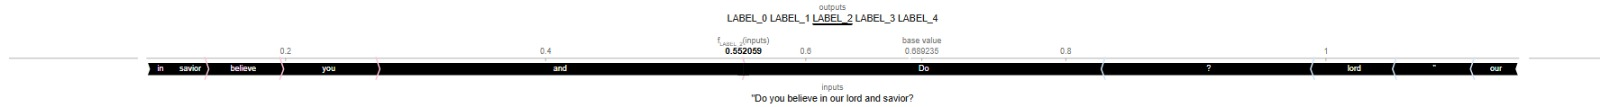

Ground truth: fear
Model predicted: joy

Model gave importance to words Do, and.
They are stopwords and models predictions should not depend on it. While we tried to remove stopwords, the accuracy reduces.

So we need better embeddings, as transformer embedding are not giving meaningful context to words in emotion classes.